# Functional analysis: progeny / dorothea

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import atlas_protocol_scripts as aps
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import decoupler as dc
import itertools
from pathlib import Path
import numpy as np
from scipy import sparse
import seaborn as sns
import urllib.request

from threadpoolctl import threadpool_limits
import multiprocessing

import os

# set PATH env variable to conda env for altair_saver which is looking for npm
os.environ["PATH"] = os.path.dirname(os.environ["_"]) + os.pathsep + os.environ["PATH"]

cpus = 16
os.environ["NUMBA_NUM_THREADS"] = str(cpus)
threadpool_limits(cpus)


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


## Configure paths

In [8]:
adata_path = "../../data/input_data_zenodo/atlas-integrated-annotated.h5ad"
results_dir = "../../data/results/10_functional_analysis"

tfnet_file = Path(results_dir, "tf_net_dorothea_hs.tsv")
pwnet_file = Path(results_dir, "pw_net_progeny_hs.tsv")



Create results directory

In [9]:
os.makedirs(results_dir, mode = 0o750, exist_ok = True)

## Load data

anndata object

In [10]:
adata = sc.read_h5ad(adata_path)

In [14]:
adata

AnnData object with n_obs × n_vars = 62119 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'cell_type', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'cell_type_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'cell_type_major', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_cell_type_tumor_predicted_colors', '_scvi', 'cell_type_coarse_colors', 'cell_type_colors', 'cell_type_major_colors', 'cell_type_predicted_colors', 'cell_type_tumor_colors', 'condition_colors', 'dataset_colors', 'doublet_status_colors', 'eve

In [15]:
adata.obs["condition"].unique()

['LUSC', 'NSCLC NOS', 'LUAD']
Categories (3, object): ['LUAD', 'LUSC', 'NSCLC NOS']

In [16]:
adata.obs["cell_type_coarse"].unique()

['B cell', 'T cell', 'Epithelial cell', 'Macrophage/Monocyte', 'Mast cell', ..., 'Stromal', 'NK cell', 'Endothelial cell', 'pDC', 'Neutrophils']
Length: 12
Categories (12, object): ['B cell', 'Endothelial cell', 'Epithelial cell', 'Macrophage/Monocyte', ..., 'Stromal', 'T cell', 'cDC', 'pDC']

Progeny and Dorothea data

In [17]:
if Path(tfnet_file).exists():
    tfnet = pd.read_csv(tfnet_file, sep="\t")
else:
    tfnet = dc.get_dorothea(organism='human', levels=['A','B','C'])
    tfnet.to_csv(tfnet_file, sep="\t", index=False)

In [18]:
if Path(pwnet_file).exists():
    pwnet = pd.read_csv(pwnet_file, sep="\t")
else:
    pwnet = dc.get_progeny(organism='human', top=100)
    pwnet.to_csv(pwnet_file, sep="\t", index=False)

## Define contrasts

In [47]:
contrasts = [
    dict(name = "LUSC_vs_LUAD", condition = "LUSC", reference = "LUAD"),
]
contrasts

[{'name': 'LUSC_vs_LUAD', 'condition': 'LUSC', 'reference': 'LUAD'}]

### create result directories for each contrast

In [144]:
for contrast in contrasts:
    res_dir = Path(results_dir, contrast["name"].replace(" ", "_"))
    os.makedirs(res_dir, mode = 0o750, exist_ok = True)
    contrast["res_dir"] = res_dir

### Define cell type class to use

In [48]:
cell_type_class = "cell_type_coarse"

In [49]:
cell_types = adata.obs[cell_type_class].unique()
cell_types

['B cell', 'T cell', 'Epithelial cell', 'Macrophage/Monocyte', 'Mast cell', ..., 'Stromal', 'NK cell', 'Endothelial cell', 'pDC', 'Neutrophils']
Length: 12
Categories (12, object): ['B cell', 'Endothelial cell', 'Epithelial cell', 'Macrophage/Monocyte', ..., 'Stromal', 'T cell', 'cDC', 'pDC']

### Create pseudobulk for each celltype using the coarse cell type annotation

In [50]:
# Store raw rounded counts in layers
adata.layers['int_counts'] = sparse.csr_matrix.ceil(adata.layers['raw_counts'])

In [51]:
# use decoupler to make pseudobulk
pdata = dc.get_pseudobulk(adata,
                          sample_col='sample',
                          groups_col=cell_type_class,
                          layer='int_counts',
                          mode='sum',
                          min_cells=10,
                          min_counts=1000
                         )
pdata

AnnData object with n_obs × n_vars = 385 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'doublet_status', 'total_counts_mito', 'pct_counts_mito', 'cell_type_coarse', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

### Run DESeq2 on pseudobulk of all celltypes from cell_type_class for each contrast

In [52]:
%%capture

# Run deseq2 on pseudobulk all cell types

for contrast in contrasts:
    de_res = {}

    for ct in cell_types:
        print("Working on: " + ct)
        pb_ct = pdata[pdata.obs[cell_type_class] == ct].copy()

        # Build DESeq2 object
        dds = DeseqDataSet(
            adata=pb_ct,
            design_factors='condition',
            refit_cooks=True,
            n_cpus=cpus,
        )

        # Compute LFCs
        dds.deseq2()

        # Extract contrast between LUAD vs LUSC
        stat_res = DeseqStats(dds, contrast=["condition", contrast["condition"], contrast["reference"]], n_cpus=cpus)

        # Compute Wald test
        stat_res.summary()

        # Shrink LFCs
        coeff = "condition_" + contrast["name"]
        stat_res.lfc_shrink(coeff=coeff);

        # Register cell type results
        de_res[ct] = stat_res.results_df
                                             
    # Register results for current contrast
    contrast["de_res"] = de_res


Check if we got a result

In [57]:
contrasts[0]["de_res"]['T cell']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,574.722839,-0.176134,0.359733,1.968212,0.049044,0.454866
A1BG-AS1,269.177856,-0.306233,0.522962,-1.405101,0.159991,0.675885
A2M,133.317184,-0.516121,0.787432,-2.254733,0.024150,0.340974
A2M-AS1,167.020325,0.168688,0.410052,1.026358,0.304723,0.799727
A2ML1,4.134258,4.955194,1.445137,3.538895,0.000402,0.045308
...,...,...,...,...,...,...
ZXDC,249.252106,-0.365659,0.520643,-1.299807,0.193667,0.705689
ZYG11A,1.356980,0.088777,0.457431,1.341416,0.179785,0.692816
ZYG11B,275.665497,-0.200807,0.416280,-0.725741,0.467997,0.873893
ZYX,1743.302856,0.704401,0.368764,-0.043823,0.965046,0.994016


In [149]:
# Concat and build the stat matrix
for contrast in contrasts:
    stat_mat = (
        pd.concat(
                [
                    res.loc[:, ["stat"]]
                    .rename(columns={"stat": ct})
                    for ct, res in contrast['de_res'].items()
                ],
                axis=1,
                sort=True,
        )
        .fillna(0)
        .T
    )
    contrast['stat_mat'] = stat_mat
    display(stat_mat)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,0.684423,-0.303548,1.601343,0.209321,0.664652,0.860196,0.000000,-0.625619,-0.074876,0.515725,...,-0.151043,-0.471421,-0.264298,0.212700,-1.551398,-0.791374,2.041125,-1.183747,0.935613,-0.438276
T cell,1.968212,-1.405101,-2.254733,1.026358,3.538895,3.018382,0.469284,-2.452540,-1.928387,1.135368,...,0.001898,-0.104951,0.463285,0.019215,-0.227251,-1.299807,1.341416,-0.725741,-0.043823,-1.022794
Epithelial cell,2.419084,0.526893,-2.169668,-0.217421,1.378207,3.885969,0.000000,-1.369695,-1.373027,-1.606962,...,0.147592,0.470640,1.003928,-1.161040,-1.137526,-1.214502,1.048548,-1.085929,-0.683787,-0.586609
Macrophage/Monocyte,1.887552,-1.810083,-1.159946,-1.056890,-0.089742,3.591771,0.647005,-0.251056,-1.113955,0.923745,...,1.158934,0.456436,1.195565,0.350645,0.693872,-1.945580,1.543994,1.193480,-1.669678,-1.845599
Mast cell,1.302298,-0.146558,-2.031083,0.782389,0.429370,1.451368,0.633780,-0.535325,-1.273304,0.000000,...,-0.398781,0.022905,0.105666,-0.805223,0.682189,0.176131,0.857360,-0.218627,0.142690,-1.842969
Plasma cell,2.342408,-0.843355,0.110927,0.351568,1.257102,1.831766,1.315403,-0.439805,-1.039953,1.386719,...,0.558146,0.771859,0.334057,-0.492667,-0.743263,1.087382,0.858017,1.008448,0.995226,1.844273
cDC,2.915271,-1.574936,-0.613001,-0.024374,0.725753,1.623600,0.597537,1.445475,-0.102699,0.732033,...,0.566662,-0.423151,-0.316143,0.009074,-0.981146,-0.898251,0.607959,0.262559,-2.403562,-1.375922
Stromal,0.137209,-2.405250,-3.248257,-1.364812,0.551220,2.935759,0.909617,-0.946916,-0.540265,1.254717,...,1.032618,0.853582,0.295237,-0.155985,1.581859,0.305391,0.588828,-0.047608,-1.333467,-1.180155
NK cell,1.725606,-1.121034,-0.458949,0.801175,1.437149,1.971736,0.936706,0.059218,-1.618588,1.008651,...,0.860220,0.914887,0.565151,0.838835,-0.497482,-0.509860,1.162220,0.314234,-0.980920,-0.686463
Endothelial cell,-0.253354,1.143024,-1.871821,-1.301253,0.838570,2.534586,0.000000,-0.732096,2.002085,0.245973,...,1.058090,1.103358,-1.199881,0.083750,1.584533,-1.167762,0.801459,0.589046,0.517857,-2.129528


### Infer pathway activities with consensus

In [151]:
# Infer pathway activities with consensus
for contrast in contrasts:
    print(contrast['name'])
    pathway_acts, pathway_pvals = dc.run_consensus(mat=contrast['stat_mat'], net=pwnet)
    contrast['pathway_acts'] = pathway_acts
    contrast['pathway_pvals'] = pathway_pvals
    display(pathway_acts)

LUSC_vs_LUAD


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
B cell,0.062939,-0.910739,-1.038329,-1.624462,0.507894,-0.351957,-0.602665,-0.378580,0.858945,0.321914,0.623660,-1.260204,-0.758539,1.988513
T cell,-0.223223,-0.729068,-0.702562,-1.049729,-2.374628,-0.569556,-0.519256,-0.246436,-0.271419,0.419378,0.666087,-0.943721,0.681331,1.493188
Epithelial cell,-0.303212,-0.303766,-0.368689,0.526601,-0.380728,-1.082579,-1.459781,-0.261235,-1.110388,-2.071201,1.249942,-0.056985,-0.302893,0.987254
Macrophage/Monocyte,-0.482002,-1.010177,-0.327329,-1.336789,-0.582139,-0.909175,-2.019901,-0.128961,-0.356757,-0.730278,0.271995,-0.331442,1.045610,1.216933
Mast cell,-0.558213,-1.169621,1.020281,-0.310194,-1.397407,-1.258175,-1.358884,-0.892186,-0.138127,-0.991052,0.665459,-0.356392,0.888819,1.105882
Plasma cell,0.469449,-1.031615,0.627337,-0.701767,-1.576447,-0.047319,-1.074090,0.449529,1.688283,-0.700847,0.954997,-0.392691,1.030743,1.051407
cDC,-0.134425,-0.613303,-0.327458,-0.409282,-1.827826,-0.578036,-1.957997,-0.171727,-0.405335,-1.117040,0.361363,-0.362108,1.299557,0.824627
Stromal,-0.354937,-0.243664,0.156538,-1.626976,-0.154900,0.430590,1.072540,-0.268128,-1.403998,-0.527387,1.749872,-1.474300,0.554584,0.759733
NK cell,-0.183768,-0.484799,-0.325389,-1.181857,-2.436950,-0.672178,-0.374020,-0.207960,1.151950,0.274978,0.427968,-0.338431,1.628383,0.340598
Endothelial cell,0.129955,0.194947,0.630472,-0.382399,-1.737014,0.313977,2.064026,0.598129,-0.733381,0.458351,1.758808,-0.049834,0.192832,0.439736


### Generate per cell type pathway activity barplots

LUSC_vs_LUAD


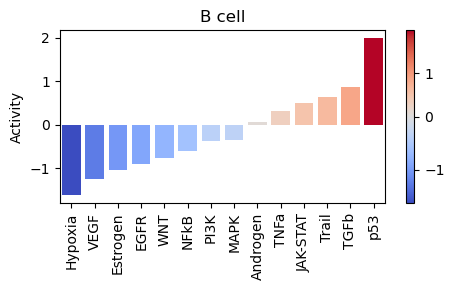

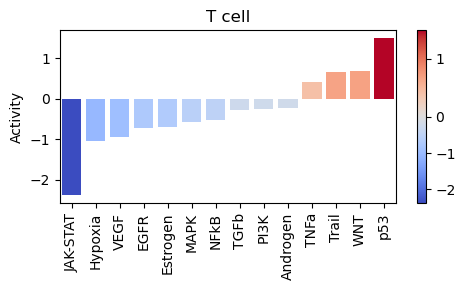

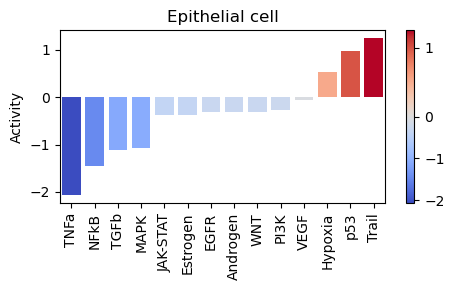

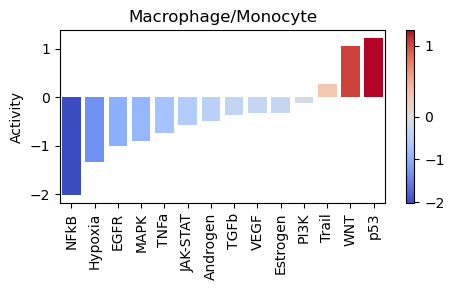

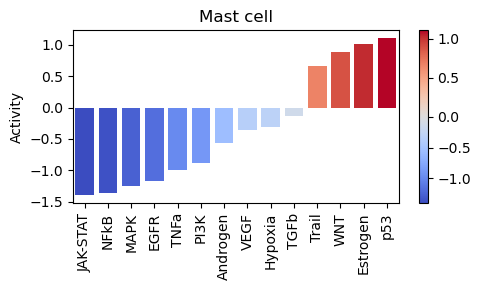

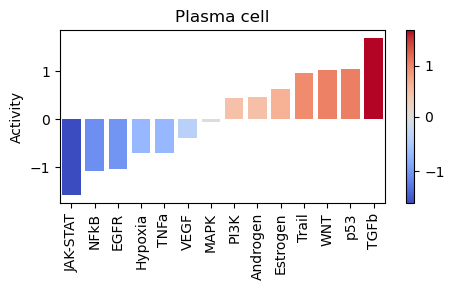

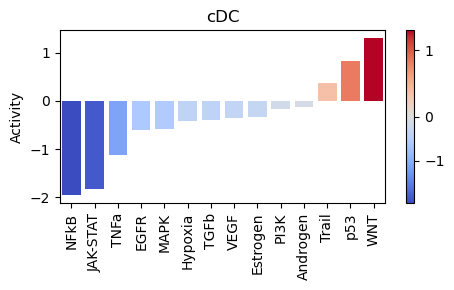

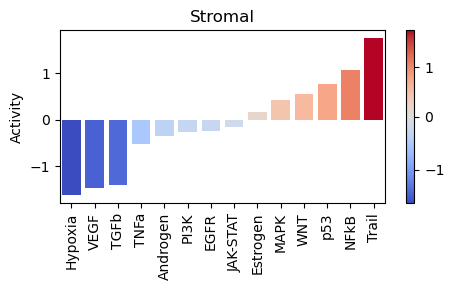

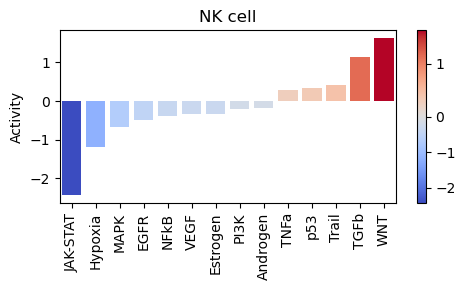

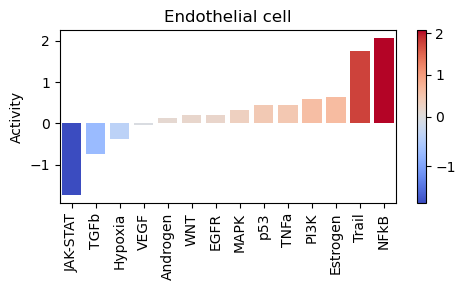

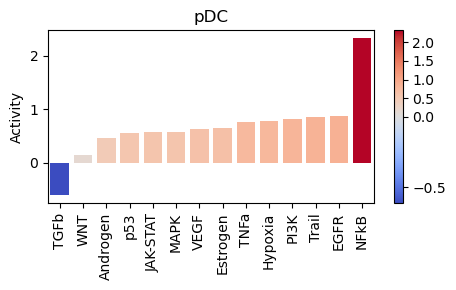

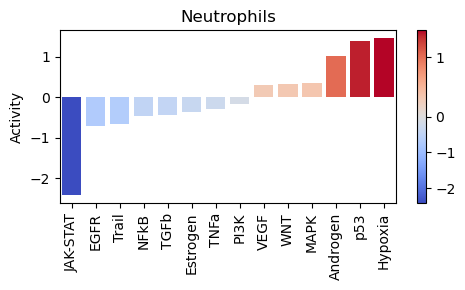

In [162]:
for contrast in contrasts:
    print(contrast['name'])
    for ct in cell_types:
        #bp = dc.plot_barplot(contrast['pathway_acts'], ct, top=25, vertical=False, return_fig=True, figsize=[5,3])
        #plt.title(ct)

        # fig, ax = plt.subplots()
        bp = dc.plot_barplot(contrast['pathway_acts'], ct, top=25, vertical=False, return_fig=True, figsize=[5,3])
        plt.title(ct)
        plt.tight_layout()
        
        if bp is not None:
            ct_fname = ct.replace(" ", "_").replace("/", "_")
            aps.pl.save_fig_mfmt(bp, 
                             res_dir=f"{contrast['res_dir']}/pathways/", 
                             filename=f"{contrast['name']}_pw_acts_barplot_{ct_fname}", 
                             fmt="all",
                             plot_provider="mpl")
        else:
            print("No plot for: " + contrast["name"] + ":" + ct)
        

### Generate pathway activity heatmap

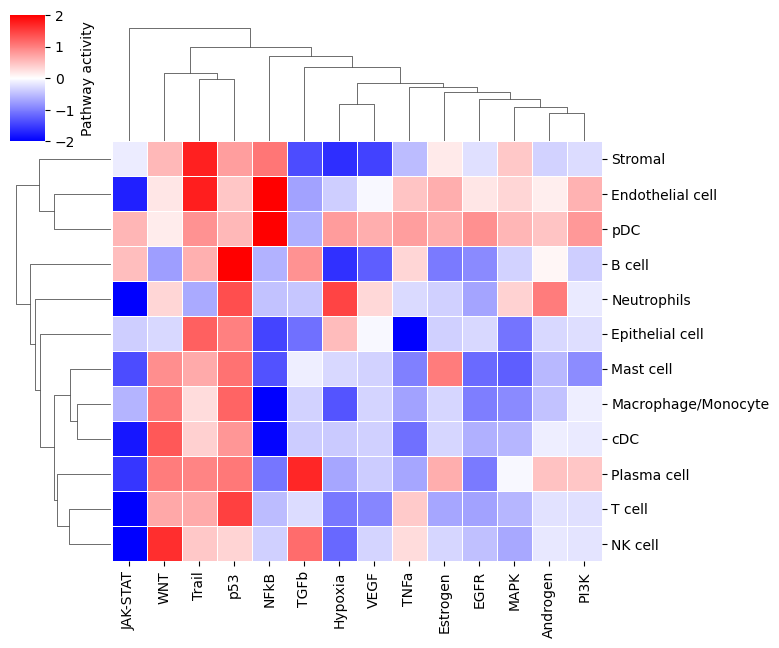

In [163]:
# generate heatmap plot
for contrast in contrasts:
    with plt.rc_context({"figure.figsize": (5.2, 5)}):
        chm = sns.clustermap(
            pathway_acts, 
            center=0, 
            cmap='bwr', 
            linewidth=0.5, 
            cbar_kws={"label": "Pathway activity"},
            vmin=-2,
            vmax=2, 
            figsize=(7,7)
        )
        aps.pl.reshape_clustermap(chm, cell_width=0.05, cell_height=0.05)
        aps.pl.save_fig_mfmt(chm, res_dir=f"{contrast['res_dir']}/pathways/", filename=f"{contrast['name']}_pw_acts_heatmap", fmt="all", plot_provider="mpl")
        plt.show()

### Save pathway activity matrix

In [164]:
# save tsv
for contrast in contrasts:
    tsv_dir = Path(contrast['res_dir'], "pathways", "tsv")
    os.makedirs(tsv_dir, mode = 0o750, exist_ok = True)
    pathway_acts.to_csv(f"{tsv_dir}/{contrast['name']}_pathway_acts.tsv", sep="\t")


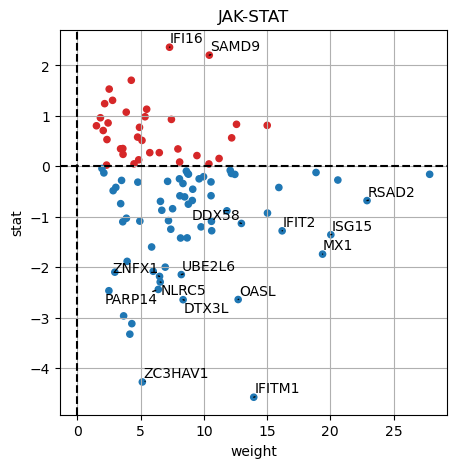

In [165]:
dc.plot_targets(de_res['T cell'], stat='stat', source_name='JAK-STAT', net=pwnet, top=15)